<VSCode.Cell id="header" language="markdown">
```ascii
╔════════════════════════════════════════════════════════════════════════════╗
║                                                                            ║
║   ███████╗████████╗██████╗  █████╗ ████████╗███████╗ ██████╗ ██╗   ██╗     ║
║   ██╔════╝╚══██╔══╝██╔══██╗██╔══██╗╚══██╔══╝██╔════╝██╔════╝ ╚██╗ ██╔╝     ║
║   ███████╗   ██║   ██████╔╝███████║   ██║   █████╗  ██║  ███╗ ╚████╔╝      ║
║   ╚════██║   ██║   ██╔══██╗██╔══██║   ██║   ██╔══╝  ██║   ██║  ╚██╔╝       ║
║   ███████║   ██║   ██║  ██║██║  ██║   ██║   ███████╗╚██████╔╝   ██║        ║
║   ╚══════╝   ╚═╝   ╚═╝  ╚═╝╚═╝  ╚═╝   ╚═╝   ╚══════╝ ╚═════╝    ╚═╝        ║
║                                                                            ║
╚════════════════════════════════════════════════════════════════════════════╝

# ML-Based Trading Strategy Backtesting

This notebook implements and evaluates a machine learning-based trading strategy using historical market data and model predictions. The strategy combines technical indicators with ML predictions to generate trading signals.

## Key Features
- 🤖 ML-driven signal generation
- 📊 Comprehensive performance metrics
- 📈 Visual performance analysis
- 💰 Risk-adjusted returns calculation
- 🔄 Walk-forward testing

## Configuration
- Initial Capital: $5,000
- Position Size: 10% per trade
- Stop Loss: 2%
- Take Profit: 5%

*Last updated: May 2025*
</VSCode.Cell>

In [1]:
# Import dependencies and setup
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from src.backtesting.strategy import TradingStrategy
from src.backtesting.ml_strategy import MLStrategy
from src.backtesting.backtest import Backtest
from src.backtesting.metrics import calculate_performance_metrics


In [4]:

# Load configuration
with open('../config.yaml', 'r') as file:
    config = yaml.safe_load(file)

# Load feature data and predictions
try:
    all_features = pd.read_pickle('../data/processed/all_features.pkl')
    y_pred = pd.read_pickle('../data/processed/predictions.pkl')
    print("Successfully loaded features and predictions")
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please run cross_asset_modeling.ipynb first to generate predictions")
    raise

# Get target symbol
target_symbol = config['target_symbol']
print(f"Analyzing strategy for {target_symbol}")

# Initialize strategy with config parameters
try:
    strategy = MLStrategy(
        initial_capital=config['backtesting']['initial_capital'],
        entry_threshold=config['backtesting']['entry_threshold'],
        exit_threshold=config['backtesting']['exit_threshold'],
        max_trades=config['backtesting']['max_trades']  # Add this line
    )
    print("Strategy initialized with parameters from config")
except KeyError as e:
    print(f"Error: Missing config parameter {e}")
    raise

# Initialize and run backtest first
backtest = Backtest(strategy=strategy, data=all_features)
results = backtest.run(predictions=y_pred)

# Then calculate trade statistics
trade_count = len(results[results['position'] != results['position'].shift(1)]) // 2
print("\nTrade Statistics:")
print(f"Total Trades: {trade_count}")
print(f"Max Trades Allowed: {config['backtesting']['max_trades']}")

# Calculate and display metrics
metrics = calculate_performance_metrics(results)

# Display performance metrics
print("\nPerformance Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

# Calculate and display capital metrics
initial_capital = config['backtesting']['initial_capital']
final_capital = initial_capital * (1 + metrics['total_return'])

print("\nCapital Summary:")
print(f"Initial Capital: ${initial_capital:,.2f}")
print(f"Final Capital:   ${final_capital:,.2f}")
print(f"Net Profit:     ${(final_capital - initial_capital):,.2f}")

Successfully loaded features and predictions
Analyzing strategy for MSFT
Strategy initialized with parameters from config

Trade Statistics:
Total Trades: 14
Max Trades Allowed: 50

Performance Metrics:
total_return: 0.1138
annualized_return: 0.0847
sharpe_ratio: 0.9289
max_drawdown: -0.0432
volatility: 0.0922
win_rate: 0.5000

Capital Summary:
Initial Capital: $5,000.00
Final Capital:   $5,568.77
Net Profit:     $568.77


C:\Users\Kenrm\AppData\Local\Temp\ipykernel_11656\867514025.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = results['strategy_returns'].resample('M').sum()


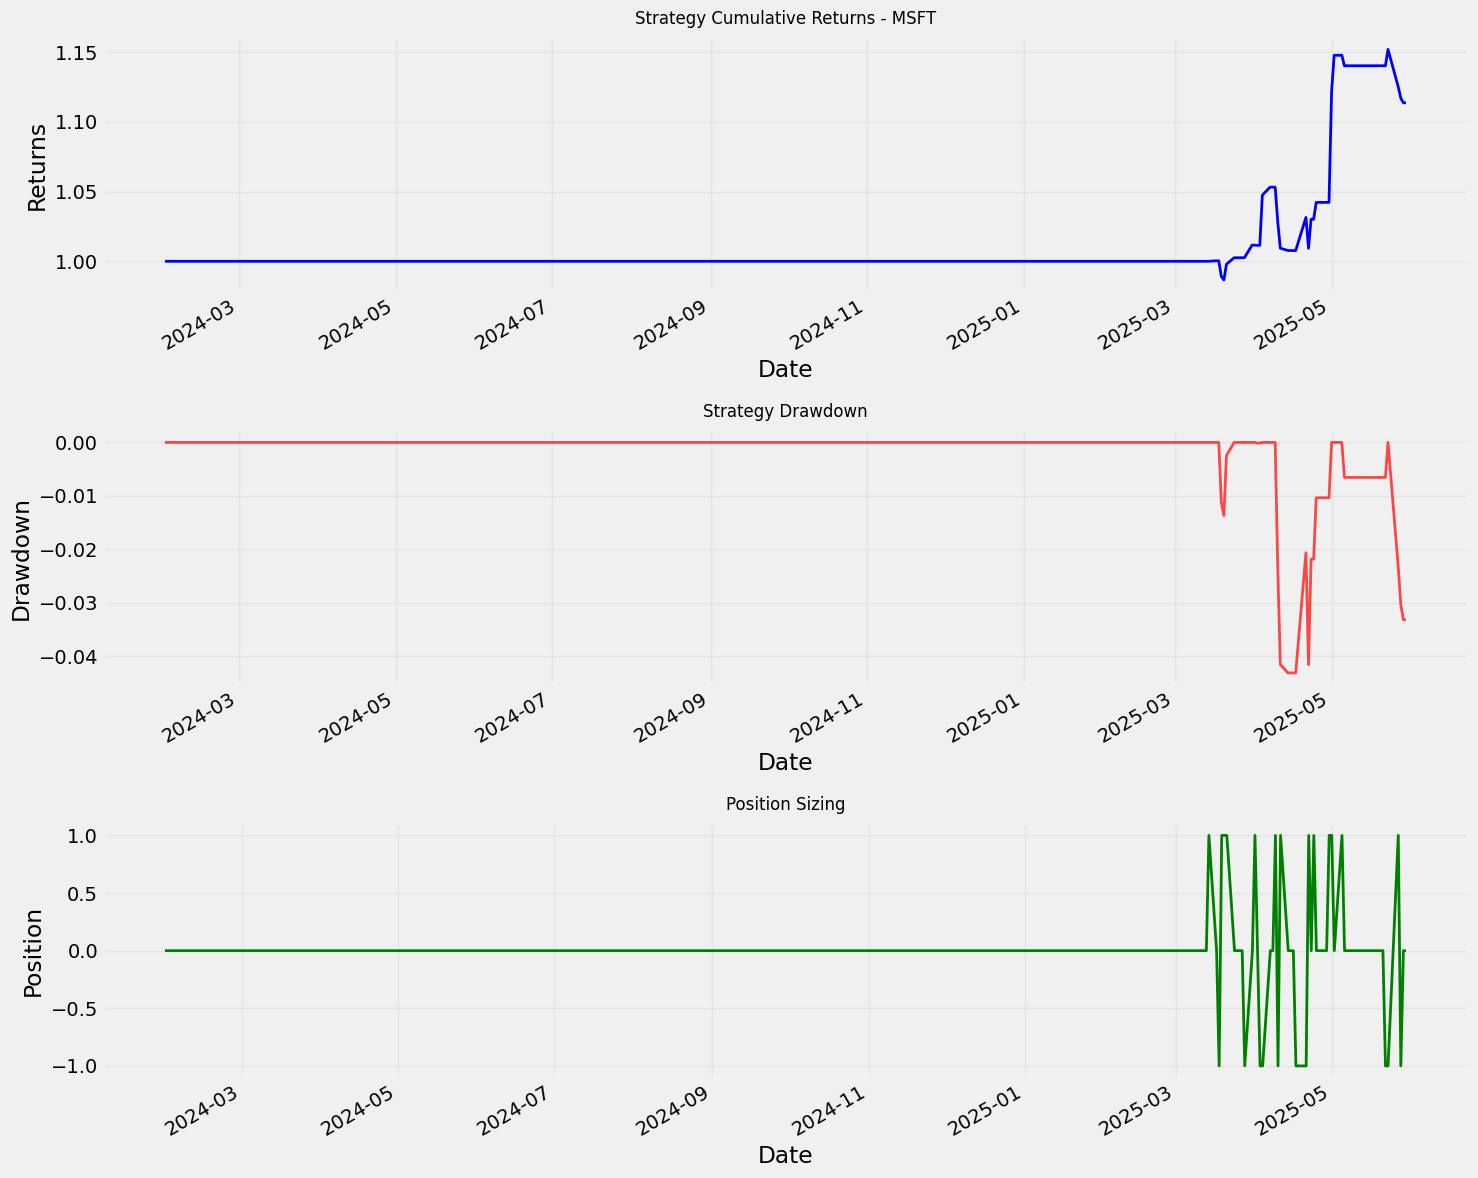

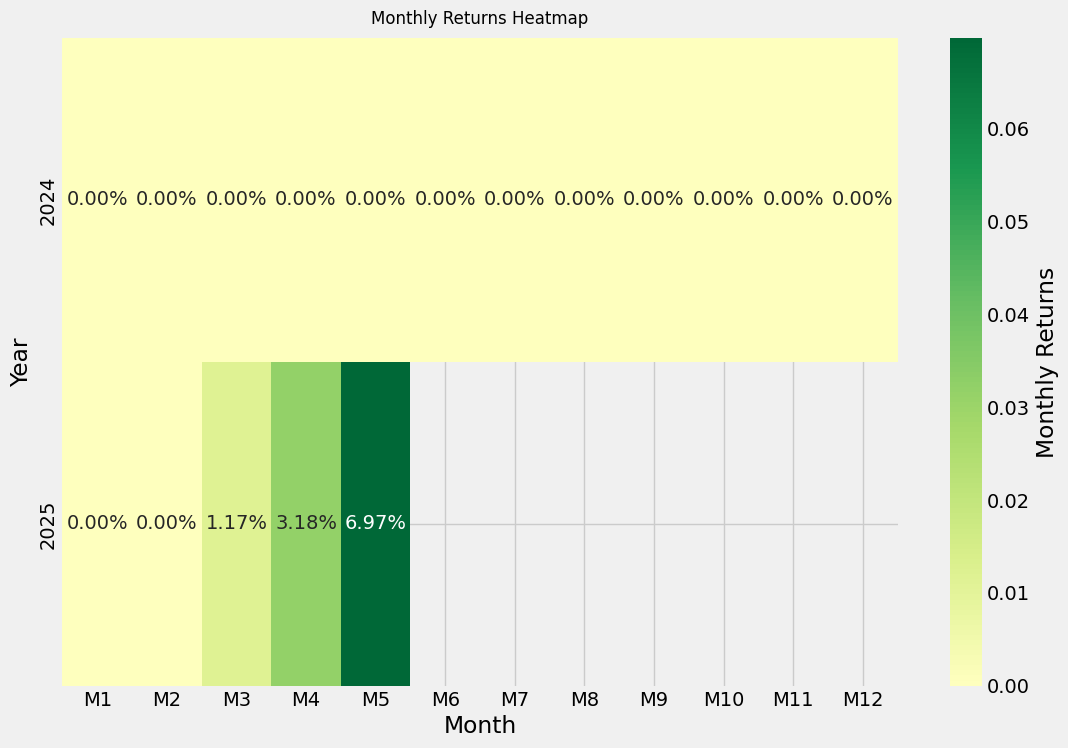

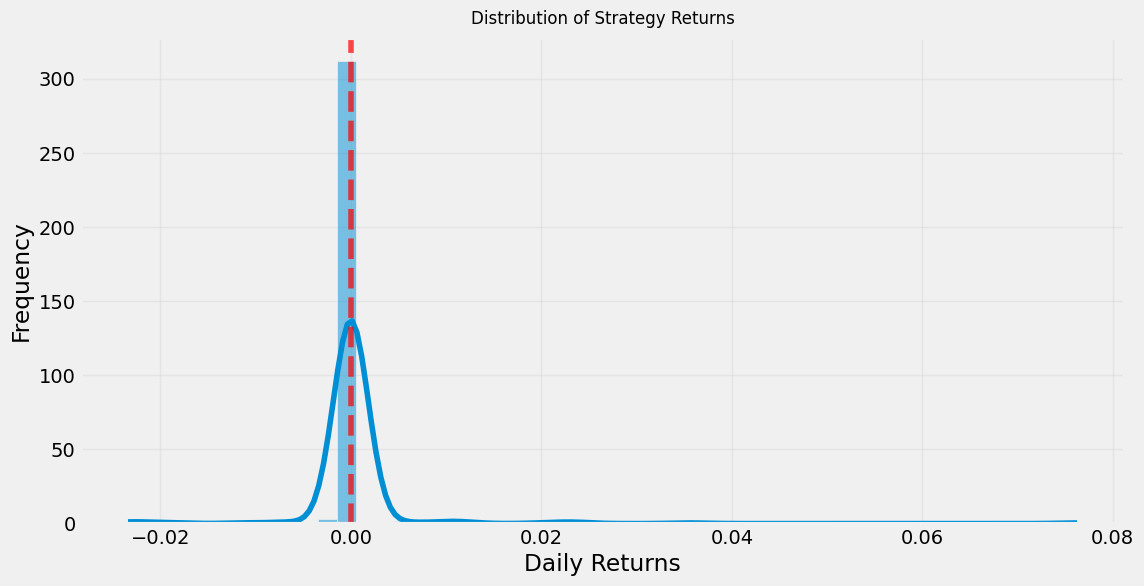

In [9]:
# Create monthly returns table for heatmap
monthly_returns = results['strategy_returns'].resample('M').sum()
monthly_returns_df = pd.DataFrame(monthly_returns)
monthly_returns_pivot = pd.pivot_table(
    monthly_returns_df,
    index=monthly_returns_df.index.year,
    columns=monthly_returns_df.index.month,
    values='strategy_returns'
)

# Set visualization style
plt.style.use('fivethirtyeight')

# Create performance visualization subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))

# Plot 1: Cumulative Returns
results['cumulative_returns'].plot(ax=ax1, color='blue', linewidth=2)
ax1.set_title(f'Strategy Cumulative Returns - {target_symbol}', fontsize=12, pad=10)
ax1.set_ylabel('Returns')
ax1.grid(True, alpha=0.3)

# Plot 2: Drawdown
results['drawdown'].plot(ax=ax2, color='red', linewidth=2, alpha=0.7)
ax2.set_title('Strategy Drawdown', fontsize=12, pad=10)
ax2.set_ylabel('Drawdown')
ax2.grid(True, alpha=0.3)

# Plot 3: Position Sizing
results['position'].plot(ax=ax3, color='green', linewidth=2)
ax3.set_title('Position Sizing', fontsize=12, pad=10)
ax3.set_ylabel('Position')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Monthly returns heatmap with corrected data
plt.figure(figsize=(12, 8))
ax = sns.heatmap(
    monthly_returns_pivot,  # Use pivoted data instead of monthly_returns
    annot=True, 
    fmt='.2%', 
    center=0,
    cmap='RdYlGn',
    cbar_kws={'label': 'Monthly Returns'}
)
plt.title('Monthly Returns Heatmap', fontsize=12, pad=10)
plt.xlabel('Month')
plt.ylabel('Year')
ax.set_xticklabels([f"M{i}" for i in range(1, 13)], rotation=0)
plt.show()

# Return distribution analysis
plt.figure(figsize=(12, 6))
sns.histplot(data=results['strategy_returns'], bins=50, kde=True)
plt.title('Distribution of Strategy Returns', fontsize=12, pad=10)
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.axvline(x=0, color='r', linestyle='--', alpha=0.7)
plt.grid(True, alpha=0.3)
plt.show()